In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd
from matplotlib import cm


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import plot_utils, data_utils
from code_utils import file_utils, grid_utils, stats_utils

In [2]:
from analyze_behav import process_behav
sublist = [1,2,3,4,5,6,7]
process_behav.preproc_main_task(sublist)
# process_behav.preproc_repeat_task(sublist)


S01: cb=1

loading from /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Session1/S01_MainTaskMRI_scannerversion_sess1_part1_210409.mat
loading from /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Session1/S01_MainTaskMRI_scannerversion_sess1_part2_210409.mat
loading from /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Session1/S01_MainTaskMRI_scannerversion_sess1_part3_210409.mat
loading from /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Session1/S01_MainTaskMRI_scannerversion_sess1_part4_210409.mat
loading from /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Session1/S01_MainTaskMRI_scannerversion_sess1_part5_210409.mat
loading from /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Session1/S01_MainTaskMRI_scannerversion_sess1_part6_210409.mat
loading from /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Session2/S01_MainTaskMRI_scannerversion_sess2_part1_210414.mat
loading from /usr/local/serenceslab/maggie/shapeDim/DataBehavior

In [5]:
all_grid_points = grid_utils.get_full_grid()
n_pts_all_grid = all_grid_points.shape[0]

grid_pts = grid_utils.get_main_grid()

In [120]:
subjects = np.arange(1,8)
n_subj = len(subjects)

task_names = ['Linear-1','Linear-2','Checker','One-Back'];
n_tasks = len(task_names)-1
acc_by_task = np.zeros((n_subj, n_tasks));
acc_by_task_easy = np.zeros((n_subj, n_tasks));
acc_by_task_hard = np.zeros((n_subj, n_tasks));

rt_by_task = np.zeros((n_subj, n_tasks));
rt_by_task_easy = np.zeros((n_subj, n_tasks));
rt_by_task_hard = np.zeros((n_subj, n_tasks));

n_runs_total = 3 * 12
acc_by_run = np.full(fill_value=np.nan, shape=(n_subj, n_runs_total));

n_runs_each_task = int(n_runs_total / n_tasks)
diff_by_task = np.full(fill_value=np.nan, shape=(n_subj, n_tasks, n_runs_each_task));

# count how many trials they respond with each category label
resp_values = ['1','2','none']
n_resp_each_point = np.zeros((n_subj, n_tasks, n_pts_all_grid, len(resp_values)))

for si, ss in enumerate(subjects):
    
    bdat = data_utils.load_main_task_labels(ss)
    
    resp = np.array(bdat['resp'])
    correct_resp = np.array(bdat['correct_resp'])
    rt = np.array(bdat['rt'])
    
    for ti in range(n_tasks):
        
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False)
        acc_by_task[si,ti] = np.mean(correct_resp[inds]==resp[inds])
        rt_by_task[si,ti] = np.mean(rt[inds])
        
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False) & (bdat['is_main_grid']==1)
        acc_by_task_easy[si,ti] = np.mean(correct_resp[inds]==resp[inds])
        rt_by_task_easy[si,ti] = np.mean(rt[inds])
        
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False) & (bdat['is_main_grid']==0)
        acc_by_task_hard[si,ti] = np.mean(correct_resp[inds]==resp[inds])
        rt_by_task_hard[si,ti] = np.mean(rt[inds])
        
        runs_this_task = np.unique(bdat['run_overall'][bdat['task']==(ti+1)])
        # print(ti, runs_this_task)
        for ri, rr in enumerate(runs_this_task):
            
            diff = np.array(bdat['run_difficulty'][bdat['run_overall']==rr])[0]
            
            diff_by_task[si,ti,ri] = diff
        
    runs_overall = np.unique(bdat['run_overall'])
    for ri,rr in enumerate(runs_overall):
        
        inds = (bdat['run_overall']==rr) & (bdat['timeout']==False)
        a = np.mean(resp[inds]==correct_resp[inds])

        acc_by_run[si,ri] = a

    # loop over all trials
    for tr in range(bdat.shape[0]):
        dat = bdat.iloc[tr]
        
        task_ind = dat['task'] - 1
        grid_point_ind = np.where((all_grid_points[:,0]==dat['ptx']) & (all_grid_points[:,1]==dat['pty']))[0]
        assert(len(grid_point_ind)==1)
        if not np.isnan(dat['resp_unmapped']):
            resp_ind = int(dat['resp_unmapped']) - 1
        else:
            resp_ind = 2;
            
        n_resp_each_point[si,task_ind,grid_point_ind[0], resp_ind] +=1

In [106]:
# load data for repeat-detection (one-back) task
acc_repeat_task = np.full(fill_value=np.nan, shape=(n_subj,1));
acc_repeat_task_easy = np.full(fill_value=np.nan, shape=(n_subj,1));
acc_repeat_task_hard = np.full(fill_value=np.nan, shape=(n_subj,1));

rt_repeat_task = np.full(fill_value=np.nan, shape=(n_subj,1));
rt_repeat_task_easy = np.full(fill_value=np.nan, shape=(n_subj,1));
rt_repeat_task_hard = np.full(fill_value=np.nan, shape=(n_subj,1));

n_runs_repeat = 3 * 4

diff_repeat_task = np.full(fill_value=np.nan, shape=(n_subj, n_runs_repeat));
acc_repeat_by_run = np.full(fill_value=np.nan, shape=(n_subj, n_runs_repeat));


for si, ss in enumerate(subjects):
    
    bdat = data_utils.load_repeat_task_labels(ss)
    
    
    resp = np.array(bdat['resp'])
    correct_resp = np.array(bdat['correct_resp'])
    rt = np.array(bdat['rt'])
    
    inds = (bdat['timeout']==False)
    acc_repeat_task[si] = np.mean(correct_resp[inds]==resp[inds])
    rt_repeat_task[si] = np.mean(rt[inds])
    
    inds = (bdat['timeout']==False) & (bdat['is_main_grid']==1)
    acc_repeat_task_easy[si] = np.mean(correct_resp[inds]==resp[inds])
    rt_repeat_task_easy[si] = np.mean(rt[inds])
    
    inds = (bdat['timeout']==False) & (bdat['is_main_grid']==0)
    acc_repeat_task_hard[si] = np.mean(correct_resp[inds]==resp[inds])
    rt_repeat_task_hard[si] = np.mean(rt[inds])
    
    runs_this_task = np.unique(np.array(bdat['run_overall']))
    for ri, rr in enumerate(runs_this_task):

        diff = np.array(bdat['run_difficulty'][bdat['run_overall']==rr])[0]

        diff_repeat_task[si,ri] = diff
   
        inds = (bdat['run_overall']==rr) & (bdat['timeout']==False)
        a = np.mean(resp[inds]==correct_resp[inds])

        acc_repeat_by_run[si,ri] = a


In [191]:
subcolors = cm.BuGn(np.linspace(0,1,n_subj+1))[1:]
# subcolors = cm.Blues(np.linspace(0,1,n_subj))
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)


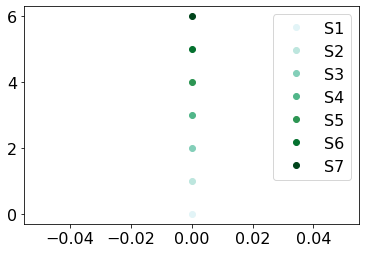

In [192]:
plt.figure()
for si in range(n_subj):
    plt.plot(0,si,'o', color=subcolors[si,:])
plt.legend(['S%0d'%ss for ss in subjects])
figfolder = os.path.join(root, 'Analysis','figures')
figname = os.path.join(figfolder, 'behav_legend.pdf')
plt.savefig(figname)

In [180]:
np.random.seed(343545)
jitters = np.linspace(-0.05, 0.05, n_subj)
jitters = jitters[np.random.permutation(len(jitters))]

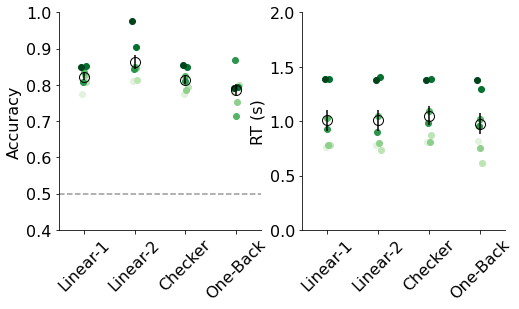

In [183]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)

plt.figure(figsize=(8,4))

ax = plt.subplot(1,2,1)

vals = np.concatenate([acc_by_task, acc_repeat_task], axis=1) 
n_tasks = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
# plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.plot(np.arange(n_tasks), meanvals, 'o', color='k', zorder=10, markersize=10, markerfacecolor='none')
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    for ti in range(vals.shape[1]):
        plt.plot(ti+jitters[si], vals[si,ti], 'o', color=subcolors[si,:], markersize=6, zorder=-10)
plt.xticks(np.arange(n_tasks), task_names, rotation=45)
plt.ylabel('Accuracy')
plt.ylim([0.4, 1.0])
plt.xlim([-0.5, 3.5])
plt.axhline(0.5, color=[0.6, 0.6, 0.6], linestyle='--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = plt.subplot(1,2,2)

vals = np.concatenate([rt_by_task, rt_repeat_task], axis=1) 
n_tasks = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)

plt.plot(np.arange(n_tasks), meanvals, 'o', color='k', zorder=10, markersize=10, markerfacecolor='none')
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    for ti in range(vals.shape[1]):
        plt.plot(ti+jitters[si], vals[si,ti], 'o', color=subcolors[si,:], markersize=6, zorder=-10)
        
plt.xticks(np.arange(n_tasks), task_names, rotation=45)
plt.ylabel('RT (s)')
plt.ylim([0, 2.0])
plt.xlim([-0.5, 3.5])
# plt.title('response time');

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

figfolder = os.path.join(root, 'Analysis','figures')
figname = os.path.join(figfolder, 'behav_4tasks.pdf')
plt.savefig(figname)

In [124]:
vals = np.concatenate([acc_by_task, acc_repeat_task], axis=1) 
stats_utils.rmanova_1way(vals,'task')

,F Value,Num DF,Den DF,Pr > F
task,5.542762,3.0,18.0,0.007116


In [ ]:
vals = np.concatenate([acc_by_task, acc_repeat_task], axis=1)


pvals = np.zeros((6,))
tstats = np.zeros((6,))

pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]

pair_names = ['%s vs %s'%(task_names[pair[0]], task_names[pair[1]]) for pair in pairs]

for pi, pair in enumerate(pairs):
    
    avals = vals[:,pair]
    
    p,t = stats_utils.paired_ttest_nonpar(avals[:,0], avals[:,1], n_iter=10000, rndseed=343455)
    
    pvals[pi] = p
    tstats[pi] = t
    

In [ ]:
pd.DataFrame({'t': tstats, 'p': pvals}, index=pair_names)

,t,p
Linear-1 vs Linear-2,-2.648525,0.0160
Linear-1 vs Checker,1.442297,0.1878
Linear-1 vs One-Back,1.577317,0.1822
Linear-2 vs Checker,3.936833,0.0160
Linear-2 vs One-Back,2.727898,0.0480
Checker vs One-Back,1.269797,0.2814


In [110]:
vals = np.concatenate([rt_by_task, rt_repeat_task], axis=1) 
stats_utils.rmanova_1way(vals,'task')

,F Value,Num DF,Den DF,Pr > F
task,3.380784,3.0,18.0,0.041036


In [127]:
vals = np.concatenate([rt_by_task, rt_repeat_task], axis=1) 


pvals = np.zeros((6,))
tstats = np.zeros((6,))

pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]

pair_names = ['%s vs %s'%(task_names[pair[0]], task_names[pair[1]]) for pair in pairs]

for pi, pair in enumerate(pairs):
    
    avals = vals[:,pair]
    
    p,t = stats_utils.paired_ttest_nonpar(avals[:,0], avals[:,1], n_iter=10000, rndseed=343455)
    
    pvals[pi] = p
    tstats[pi] = t
    

In [128]:
pd.DataFrame({'t': tstats, 'p': pvals}, index=pair_names)

,t,p
Linear-1 vs Linear-2,0.339797,0.7918
Linear-1 vs Checker,-3.148185,0.0460
Linear-1 vs One-Back,1.206425,0.2992
Linear-2 vs Checker,-2.171440,0.0590
Linear-2 vs One-Back,1.197150,0.2954
Checker vs One-Back,2.170416,0.0454


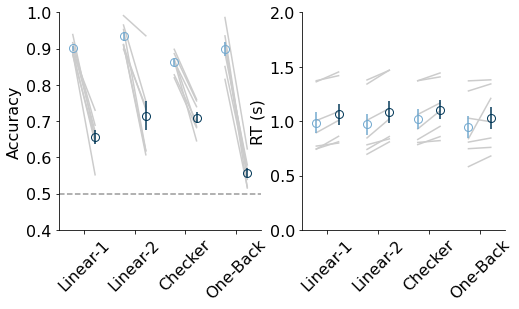

In [188]:
plt.figure(figsize=(8,4))
jitters =np.linspace(-0.22, 0.22, 2)



ax = plt.subplot(1,2,1)
colors = cm.PuBu(np.linspace(0,1,5))[[2,4],:]

vals1 = np.concatenate([acc_by_task_easy[:,:,None], acc_by_task_hard[:,:,None]], axis=2)
vals2 = np.concatenate([acc_repeat_task_easy[:,:,None], acc_repeat_task_hard[:,:,None]], axis=2)
vals = np.concatenate([vals1, vals2], axis=1)

n_tasks = vals.shape[1]

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)


for ji in range(2):
    
    plt.plot(np.arange(n_tasks)+jitters[ji], meanvals[:,ji], 'o', color=colors[ji,:],markersize=8, markerfacecolor='none')
    plt.errorbar(np.arange(n_tasks)+jitters[ji], meanvals[:,ji], semvals[:,ji], \
                 linestyle='none', color=colors[ji,:])

for ti in range(4):
    
    # plt.plot(ti+jitters, vals[:,ti,:].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
    plt.plot(ti+jitters, vals[:,ti,:].T, '-', color=[0.8, 0.8, 0.8], zorder=-10)
    
plt.ylim([0.4,1.0])
plt.xlim([-0.5, 3.5])
# plt.title('response time');

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(n_tasks), task_names, rotation=45)
plt.ylabel('Accuracy')

plt.axhline(0.5, color=[0.6, 0.6, 0.6], linestyle='--')




ax = plt.subplot(1,2,2)

vals1 = np.concatenate([rt_by_task_easy[:,:,None], rt_by_task_hard[:,:,None]], axis=2)
vals2 = np.concatenate([rt_repeat_task_easy[:,:,None], rt_repeat_task_hard[:,:,None]], axis=2)
vals = np.concatenate([vals1, vals2], axis=1)

n_tasks = vals.shape[1]

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)

for ji in range(2):
    
    plt.plot(np.arange(n_tasks)+jitters[ji], meanvals[:,ji], 'o', color=colors[ji,:],markersize=8, markerfacecolor='none')
    plt.errorbar(np.arange(n_tasks)+jitters[ji], meanvals[:,ji], semvals[:,ji], \
                 linestyle='none', color=colors[ji,:])

for ti in range(4):
    
    # plt.plot(ti+jitters, vals[:,ti,:].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
    plt.plot(ti+jitters, vals[:,ti,:].T, '-', color=[0.8, 0.8, 0.8], zorder=-10)
    
plt.ylim([0, 2.0])
plt.xlim([-0.5, 3.5])
# plt.title('response time');

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(n_tasks), task_names, rotation=45)
plt.ylabel('RT (s)')

# plt.axhline(0.5, color=[0.6, 0.6, 0.6], linestyle='--')

figfolder = os.path.join(root, 'Analysis','figures')
figname = os.path.join(figfolder, 'behav_easyhard.pdf')
plt.savefig(figname)

In [157]:
meanvals

array([[0.9017316 , 0.6559585 ],
       [0.93412918, 0.71545788],
       [0.86232365, 0.70981377],
       [0.8998292 , 0.55782961]])

In [156]:
np.arange(n_tasks)+jitters[ji]

array([0.2, 1.2, 2.2, 3.2])

<Figure size 432x288 with 0 Axes>

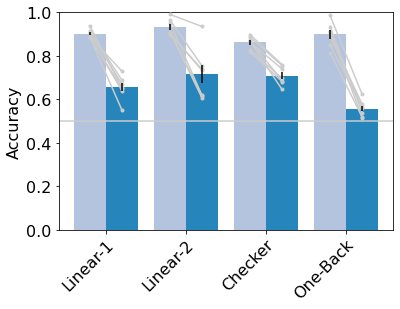

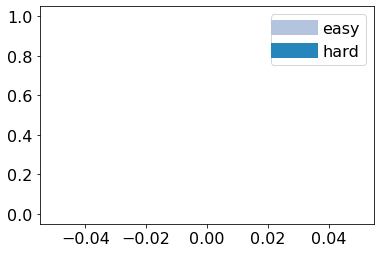

<Figure size 432x288 with 0 Axes>

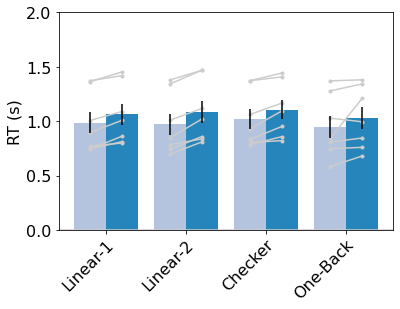

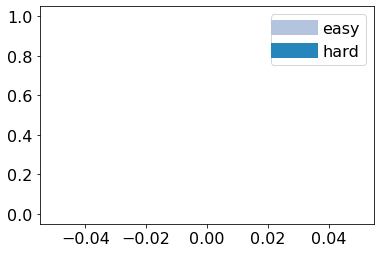

In [144]:
plt.figure(figsize=(6,4))

vals1 = np.concatenate([rt_by_task_easy[:,:,None], rt_by_task_hard[:,:,None]], axis=2)
vals2 = np.concatenate([rt_repeat_task_easy[:,:,None], rt_repeat_task_hard[:,:,None]], axis=2)
vals = np.concatenate([vals1, vals2], axis=1)

n_tasks = vals.shape[1]

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, point_data=vals, \
                           fig_size=(6,4), space = 0.1, \
                           add_ss_lines=True,
                          colors = cm.PuBu(np.linspace(0,1,4))[1:3,:], \
                          legend_labels = ['easy','hard'], \
                          ylim = [0, 2], \
                          horizontal_line_pos = 0, \
                          xticklabels = task_names, \
                          ylabel='RT (s)');

In [45]:
vals = np.concatenate([acc_by_task_easy[:,:,None], acc_by_task_hard[:,:,None]], axis=2)

stats_utils.rmanova_2way(vals,['task','difficulty'])

,F Value,Num DF,Den DF,Pr > F
task,4.588757,2.0,12.0,0.033101
difficulty,117.129393,1.0,6.0,0.000037
task:difficulty,4.984829,2.0,12.0,0.026555


In [46]:
vals = np.concatenate([rt_by_task_easy[:,:,None], rt_by_task_hard[:,:,None]], axis=2)

stats_utils.rmanova_2way(vals,['task','difficulty'])

,F Value,Num DF,Den DF,Pr > F
task,4.003481,2.0,12.0,0.046559
difficulty,42.086093,1.0,6.0,0.000638
task:difficulty,5.085840,2.0,12.0,0.025136


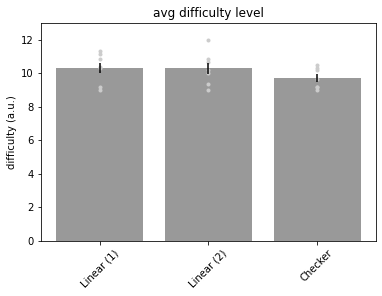

In [13]:
meandiff = np.nanmean(diff_by_task, axis=2)
vals = meandiff
n_tasks = meandiff.shape[1]

plt.figure(figsize=(6,4))

meanvals = np.nanmean(vals, axis=0)
semvals = np.nanstd(vals, axis=0)/np.sqrt(np.sum(~np.isnan(vals), axis=0))

plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), task_names, rotation=45)
plt.ylabel('difficulty (a.u.)')
plt.ylim([0,13])
# plt.axhline(0.5, color='k', linestyle='--')
plt.title('avg difficulty level');

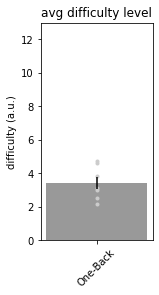

In [14]:
meandiff = np.nanmean(diff_repeat_task, axis=1, keepdims=True)
vals = meandiff
n_tasks = meandiff.shape[1]

plt.figure(figsize=(2,4))

meanvals = np.nanmean(vals, axis=0)
semvals = np.nanstd(vals, axis=0)/np.sqrt(np.sum(~np.isnan(vals), axis=0))

plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), ['One-Back'], rotation=45)
plt.ylabel('difficulty (a.u.)')
plt.ylim([0,13])
# plt.axhline(0.5, color='k', linestyle='--')
plt.title('avg difficulty level');

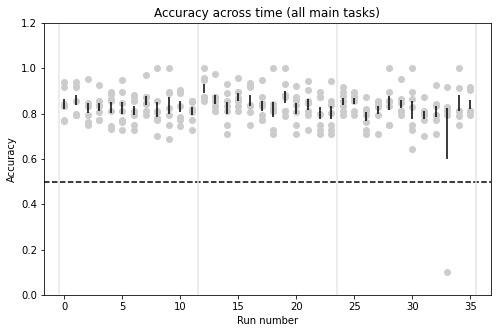

In [15]:
plt.figure(figsize=(8,5))
for ri in range(n_runs_total):
    vals = acc_by_run[:,ri]
    vals = vals[~np.isnan(vals)]
    plt.plot(ri*np.ones(np.shape(vals)), vals, 'o', color=[0.8, 0.8, 0.8])
    m = np.mean(vals)
    s = np.std(vals)/np.sqrt(len(vals))
    plt.errorbar(ri, m, s, color='k', zorder=10)
    
plt.ylabel('Accuracy')
plt.axhline(0.5, color='k', linestyle='--')
plt.title('Accuracy across time (all main tasks)');
plt.xlabel('Run number');
plt.ylim([0.0, 1.2]);

for se in np.arange(0, 37, 12):
    plt.axvline(se-0.5, color=[0.9, 0.9, 0.9]);

(-1.0, 12.0)

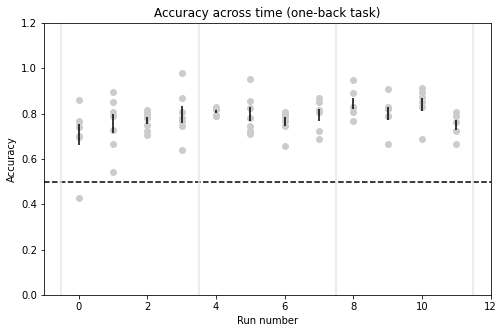

In [16]:
plt.figure(figsize=(8,5))
for ri in range(n_runs_repeat):
    vals = acc_repeat_by_run[:,ri]
    vals = vals[~np.isnan(vals)]
    plt.plot(ri*np.ones(np.shape(vals)), vals, 'o', color=[0.8, 0.8, 0.8])
    m = np.mean(vals)
    s = np.std(vals)/np.sqrt(len(vals))
    plt.errorbar(ri, m, s, color='k', zorder=10)
    
plt.ylabel('Accuracy')
plt.axhline(0.5, color='k', linestyle='--')
plt.title('Accuracy across time (one-back task)');
plt.xlabel('Run number');
plt.ylim([0.0, 1.2]);

for se in np.arange(0, 13, 4):
    plt.axvline(se-0.5, color=[0.9, 0.9, 0.9]);
plt.xlim([-1, n_runs_repeat])

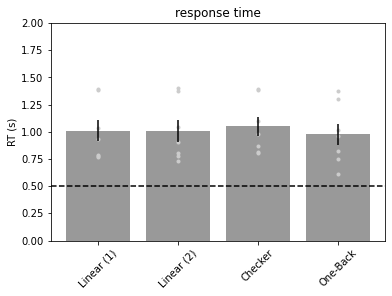

In [17]:
plt.figure(figsize=(6,4))

vals = np.concatenate([rt_by_task, rt_repeat_task], axis=1) 
n_tasks = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), task_names + ['One-Back'], rotation=45)
plt.ylabel('RT (s)')
plt.ylim([0, 2.0])
plt.axhline(0.5, color='k', linestyle='--')
plt.title('response time');

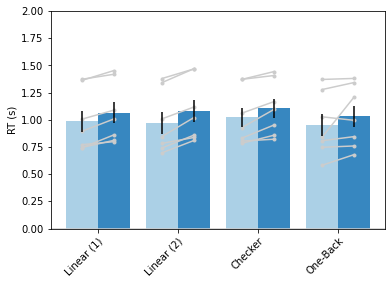

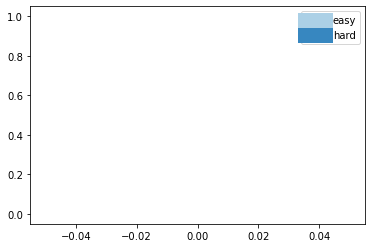

In [18]:
from code_utils import plot_utils
from matplotlib import cm

vals1 = np.concatenate([rt_by_task_easy[:,:,None], rt_by_task_hard[:,:,None]], axis=2)
vals2 = np.concatenate([rt_repeat_task_easy[:,:,None], rt_repeat_task_hard[:,:,None]], axis=2)
vals =np.concatenate([vals1, vals2], axis=1)
n_tasks = vals.shape[1]

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, point_data=vals, \
                           fig_size=(6,4), space = 0.1, \
                           add_ss_lines=True,
                          colors = cm.Blues(np.linspace(0,1,4))[1:3,:], \
                          legend_labels = ['easy','hard'], \
                          ylim = [0, 2], \
                          horizontal_line_pos = 0, \
                          xticklabels = task_names + ['One-Back'], \
                          ylabel='RT (s)');


In [19]:
from code_utils import data_utils

lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    lab[ss] = main_labels
   

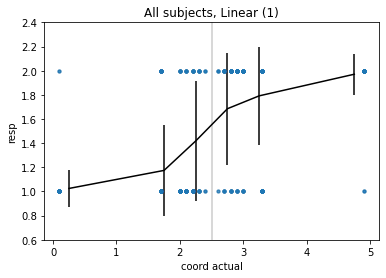

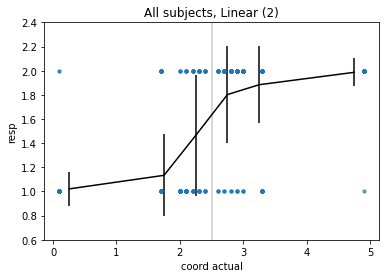

In [20]:
for ti, tt in enumerate([1,2]):

    x = []
    y = []

    for si, ss in enumerate(sublist):

        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = np.array(l['is_main_grid']==1)

        coord_actual = pt_labs[:,ti]

        resp = np.array(l['resp_unmapped']).astype(int)
        resp[~np.isin(resp, [1,2])] = 0

        x.append(coord_actual)
        y.append(resp)

    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)

    n_bins = 10;

    x_bin_edges = np.linspace(0, 5.0001, n_bins+1)
    x_binned = np.zeros((n_bins,))
    y_binned = np.zeros((n_bins,2))

    for bi in range(n_bins):
        inds = (x>=x_bin_edges[bi]) & (x<x_bin_edges[bi+1]) & (y>0)
        if np.sum(inds)>0:
            assert(not np.any(np.isnan(y[inds])))
            x_binned[bi] = np.mean(x_bin_edges[bi:bi+2])
            y_binned[bi,0] = np.mean(y[inds])
            y_binned[bi,1] = np.std(y[inds])
        else:
            x_binned[bi] = np.nan
    keep_inds = ~np.isnan(x_binned)
    x_binned = x_binned[keep_inds]
    y_binned = y_binned[keep_inds,:]

    plt.figure()

    inds = y>0
    plt.plot(x[inds], y[inds], '.', alpha=0.1)

    plt.errorbar(x_binned, y_binned[:,0], y_binned[:,1], color='k')
    plt.xlabel('coord actual')
    plt.ylabel('resp')

    plt.title('All subjects, %s'%(task_names[ti]));
    # plt.xlim([-0.2, 5.2])
    plt.ylim([0.6, 2.4])   
    plt.axvline(2.5, color=[0.8,0.8,0.8])

#### RT versus position in shape space

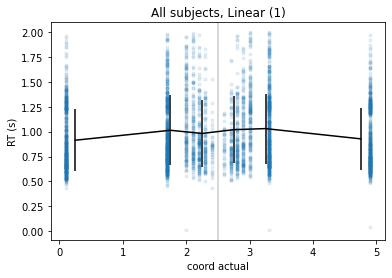

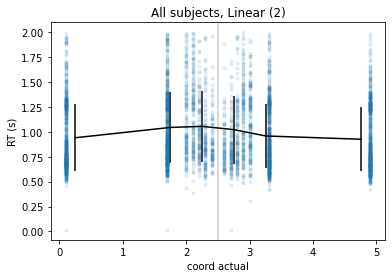

In [21]:
for ti, tt in enumerate([1,2]):

    x = []
    y = []

    for si, ss in enumerate(sublist):

        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = np.array(l['is_main_grid']==1)

        coord_actual = pt_labs[:,ti]

        rt = np.array(l['rt'])
        
        x.append(coord_actual)
        y.append(rt)

    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)

    n_bins = 10;

    x_bin_edges = np.linspace(0, 5.0001, n_bins+1)
    x_binned = np.zeros((n_bins,))
    y_binned = np.zeros((n_bins,2))

    for bi in range(n_bins):
        inds = (x>=x_bin_edges[bi]) & (x<x_bin_edges[bi+1]) & ~np.isnan(y)
        if np.sum(inds)>0:
            assert(not np.any(np.isnan(y[inds])))
            x_binned[bi] = np.mean(x_bin_edges[bi:bi+2])
            y_binned[bi,0] = np.mean(y[inds])
            y_binned[bi,1] = np.std(y[inds])
        else:
            x_binned[bi] = np.nan
    keep_inds = ~np.isnan(x_binned)
    x_binned = x_binned[keep_inds]
    y_binned = y_binned[keep_inds,:]

    plt.figure()

    inds = ~np.isnan(y)
    plt.plot(x[inds], y[inds], '.', alpha=0.1)

    plt.errorbar(x_binned, y_binned[:,0], y_binned[:,1], color='k')
    plt.xlabel('coord actual')
    plt.ylabel('RT (s)')

    plt.title('All subjects, %s'%(task_names[ti]));
    # plt.xlim([-0.2, 5.2])
    # plt.ylim([0.6, 2.4])   
    plt.axvline(2.5, color=[0.8,0.8,0.8])